In [1]:
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
from scipy import stats, integrate
import matplotlib.pyplot as plt

In [3]:
import seaborn as sns
import shutil
from sklearn.utils import shuffle

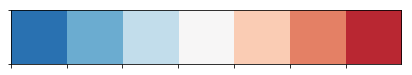

In [4]:
import seaborn as sns
sns.palplot(sns.color_palette("RdBu_r", 7))

sns.set_style("whitegrid")

# Importando base de dados

<p>Base com todos os dados do sudeste</p>

In [5]:
df = pd.read_csv('../data/sudeste.csv',low_memory=False)
print len(df)

9779168


# Pré-processamento

<h3>Limpeza dos dados</h3>

In [6]:
# Campos não numericos e campos derivados
DES= ['wsid','wsnm','elvt','lat','lon','inme','city','prov']
INT = ['yr','mo','da','hr']
DAT = ['mdct','date']
DER = ['smax','smin','tmax','tmin','dmax','dmin','hmax','hmin']

In [7]:
# dataframe apenas com os dados continuos
dfcont = df
for f in DES + INT + DAT:    
    dfcont = dfcont.drop(f, 1)

In [8]:
dfcont = dfcont.apply(pd.to_numeric, errors='coerce')  

In [9]:
dfcont.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9779168 entries, 0 to 9779167
Data columns (total 17 columns):
prcp    float64
stp     float64
smax    float64
smin    float64
gbrd    float64
temp    float64
tmax    float64
tmin    float64
dewp    float64
dmax    float64
dmin    float64
hmdy    float64
hmax    float64
hmin    float64
wdsp    float64
wdct    float64
gust    float64
dtypes: float64(17)
memory usage: 1.2 GB


In [10]:
dfcont.describe().T

,count,mean,std,min,25%,50%,75%,max
prcp,1407984.0,0.936654,2.923291,0.0,0.0,0.000,0.6,100.000
stp,9779168.0,880.429177,248.264986,0.0,911.3,944.200,973.1,1050.000
smax,9779168.0,880.303394,248.917148,0.0,911.5,944.400,973.3,1050.000
smin,9779168.0,879.833097,248.771557,0.0,911.0,943.900,972.8,1050.000
gbrd,5670348.0,1176.371062,1138.753521,0.0,65.0,863.427,2103.0,11586.491
temp,9779137.0,20.474225,7.331125,-3.8,17.7,21.400,24.9,44.900
tmax,9778693.0,14.726810,5.805413,-10.0,12.1,16.100,18.9,42.700
tmin,9779142.0,21.105026,7.545549,-3.2,18.2,21.900,25.8,45.000
dewp,9778858.0,15.240249,5.866811,-10.0,12.7,16.600,19.4,44.800
dmax,9779134.0,19.864175,7.134849,-8.5,17.2,20.800,24.2,45.000


<p> A variável gbbr(radiação global) apresenta massivamente números nulos e não pode ser recuperada. Vamos retirar esta variável.</p>

In [11]:
dfcont =  dfcont.drop('gbrd',1)
df = df.drop('gbrd',1)

<p>Para as precipitações nulas foi inputado 0.0 mm. Também para o vento e rajada de vento.</p>

In [12]:
CAN_BE_NULL = ['wdsp','prcp','gust']

In [13]:
for v in CAN_BE_NULL:
    df[v] = df[v].fillna(0.0)
    dfcont[v] = dfcont[v].fillna(0.0)  

<p>Vamos ver como os dados contínuos estão organizados: MÍNIMOS, MÁXIMOS, MEDIAS</p>

In [14]:
dfcont.describe().T

,count,mean,std,min,25%,50%,75%,max
prcp,9779168.0,0.134858,1.156940,0.0,0.0,0.0,0.0,100.0
stp,9779168.0,880.429177,248.264986,0.0,911.3,944.2,973.1,1050.0
smax,9779168.0,880.303394,248.917148,0.0,911.5,944.4,973.3,1050.0
smin,9779168.0,879.833097,248.771557,0.0,911.0,943.9,972.8,1050.0
temp,9779137.0,20.474225,7.331125,-3.8,17.7,21.4,24.9,44.9
tmax,9778693.0,14.726810,5.805413,-10.0,12.1,16.1,18.9,42.7
tmin,9779142.0,21.105026,7.545549,-3.2,18.2,21.9,25.8,45.0
dewp,9778858.0,15.240249,5.866811,-10.0,12.7,16.6,19.4,44.8
dmax,9779134.0,19.864175,7.134849,-8.5,17.2,20.8,24.2,45.0
dmin,9778361.0,14.220885,5.777089,-10.0,11.6,15.6,18.4,44.9


<p>A temperatura será inputada pela média</p>

In [15]:
MEAN = ['temp','dewp']

In [16]:
for v in MEAN:
    df[v] = df[v].fillna(value=df[v].median())
    dfcont[v] = dfcont[v].fillna(value=dfcont[v].median())

In [17]:
dfcont.describe().T

,count,mean,std,min,25%,50%,75%,max
prcp,9779168.0,0.134858,1.156940,0.0,0.0,0.0,0.0,100.0
stp,9779168.0,880.429177,248.264986,0.0,911.3,944.2,973.1,1050.0
smax,9779168.0,880.303394,248.917148,0.0,911.5,944.4,973.3,1050.0
smin,9779168.0,879.833097,248.771557,0.0,911.0,943.9,972.8,1050.0
temp,9779168.0,20.474228,7.331113,-3.8,17.7,21.4,24.9,44.9
tmax,9778693.0,14.726810,5.805413,-10.0,12.1,16.1,18.9,42.7
tmin,9779142.0,21.105026,7.545549,-3.2,18.2,21.9,25.8,45.0
dewp,9779168.0,15.240292,5.866723,-10.0,12.7,16.6,19.4,44.8
dmax,9779134.0,19.864175,7.134849,-8.5,17.2,20.8,24.2,45.0
dmin,9778361.0,14.220885,5.777089,-10.0,11.6,15.6,18.4,44.9


In [18]:
for v in ['tmax','tmin']:
    dfcont[v] = dfcont[v].fillna(value=dfcont['temp'])
    df[v] = df[v].fillna(value=df['temp'])
for v in ['dmax','dmin']:
    dfcont[v] = dfcont[v].fillna(value=dfcont['dewp'])
    df[v] = df[v].fillna(value=df['dewp'])
for v in ['hmax','hmin']:
    dfcont[v] = dfcont[v].fillna(value=dfcont['hmdy'])
    df[v] = df[v].fillna(value=df['hmdy'])

In [19]:
dfcont.describe().T

,count,mean,std,min,25%,50%,75%,max
prcp,9779168.0,0.134858,1.156940,0.0,0.0,0.0,0.0,100.0
stp,9779168.0,880.429177,248.264986,0.0,911.3,944.2,973.1,1050.0
smax,9779168.0,880.303394,248.917148,0.0,911.5,944.4,973.3,1050.0
smin,9779168.0,879.833097,248.771557,0.0,911.0,943.9,972.8,1050.0
temp,9779168.0,20.474228,7.331113,-3.8,17.7,21.4,24.9,44.9
tmax,9779168.0,14.727113,5.805794,-10.0,12.1,16.1,18.9,42.7
tmin,9779168.0,21.104973,7.545616,-3.2,18.2,21.9,25.8,45.0
dewp,9779168.0,15.240292,5.866723,-10.0,12.7,16.6,19.4,44.8
dmax,9779168.0,19.864112,7.134923,-8.5,17.2,20.8,24.2,45.0
dmin,9779168.0,14.219949,5.777816,-10.0,11.6,15.6,18.4,44.9


<h3>Pearson Correlation Heatmap</h3>

In [20]:
# dataframe apenas com os dados continuos
dfm = df
dfm.index = pd.to_datetime(dfm.mdct)
for f in DES + INT + DAT:    
    dfm = dfm.drop(f, 1)

In [21]:
dfm = dfm.reset_index(drop=True)

In [22]:
dfm = dfm.dropna()  

In [23]:
dfm.head(5)

,prcp,stp,smax,smin,temp,tmax,tmin,dewp,dmax,dmin,hmdy,hmax,hmin,wdsp,wdct,gust
0,0.0,982.5,982.5,981.3,29.3,12.1,29.7,16.8,25.5,10.8,35.0,58.0,32.0,3.2,101.0,6.5
1,0.0,983.2,983.2,982.5,29.0,13.5,29.9,13.6,29.0,12.2,39.0,39.0,35.0,3.6,94.0,6.4
2,0.0,983.5,983.5,983.2,27.4,14.0,29.0,14.0,27.4,13.6,44.0,44.0,39.0,2.5,93.0,6.9
3,0.0,983.7,983.7,983.4,25.8,16.9,27.4,16.9,25.8,14.1,58.0,58.0,44.0,1.7,96.0,5.8
4,0.0,983.7,983.8,983.6,25.4,16.4,26.3,17.0,25.3,16.4,57.0,58.0,56.0,3.1,110.0,7.5


In [24]:
dfm.describe().T

,count,mean,std,min,25%,50%,75%,max
prcp,9779168.0,0.134858,1.156940,0.0,0.0,0.0,0.0,100.0
stp,9779168.0,880.429177,248.264986,0.0,911.3,944.2,973.1,1050.0
smax,9779168.0,880.303394,248.917148,0.0,911.5,944.4,973.3,1050.0
smin,9779168.0,879.833097,248.771557,0.0,911.0,943.9,972.8,1050.0
temp,9779168.0,20.474228,7.331113,-3.8,17.7,21.4,24.9,44.9
tmax,9779168.0,14.727113,5.805794,-10.0,12.1,16.1,18.9,42.7
tmin,9779168.0,21.104973,7.545616,-3.2,18.2,21.9,25.8,45.0
dewp,9779168.0,15.240292,5.866723,-10.0,12.7,16.6,19.4,44.8
dmax,9779168.0,19.864112,7.134923,-8.5,17.2,20.8,24.2,45.0
dmin,9779168.0,14.219949,5.777816,-10.0,11.6,15.6,18.4,44.9


In [25]:
cols = list(dfm.columns)

COLS_BE_NULL = ['prcp','wdsp','gust']
for v in COLS_BE_NULL:
    cols.remove(v)
dfm[cols] = dfm[cols].replace({0.0:np.nan})

In [26]:
dfm.describe().T

,count,mean,std,min,25%,50%,75%,max
prcp,9779168.0,0.134858,1.156940,0.0,0.0,0.0,0.0,100.0
stp,9077445.0,948.489893,42.956582,816.8,916.7,948.2,981.3,1050.0
smax,9073730.0,948.742665,42.959864,817.1,917.0,948.4,981.6,1050.0
smin,9073810.0,948.227445,42.950302,816.7,916.5,947.9,981.1,1050.0
temp,9150557.0,21.880735,5.163518,-3.8,18.6,21.8,25.2,44.9
tmax,9073319.0,15.872793,4.259615,-10.0,13.2,16.5,19.1,42.7
tmin,9147695.0,22.561867,5.291165,-3.2,19.1,22.4,26.1,45.0
dewp,9072555.0,16.427278,4.195256,-10.0,13.7,17.1,19.6,44.8
dmax,9147758.0,21.235201,5.030461,-8.5,18.1,21.2,24.5,45.0
dmin,9064222.0,15.341556,4.336944,-10.0,12.6,16.0,18.6,44.9


In [27]:
dfm = dfm.dropna()

In [28]:
dfm.describe().T

,count,mean,std,min,25%,50%,75%,max
prcp,8738653.0,0.142975,1.190851,0.0,0.0,0.0,0.0,100.0
stp,8738653.0,948.661811,41.525583,816.8,917.0,948.0,979.1,1050.0
smax,8738653.0,948.921212,41.530238,817.1,917.2,948.2,979.4,1050.0
smin,8738653.0,948.404601,41.521822,816.7,916.7,947.7,978.8,1047.6
temp,8738653.0,21.927307,5.133983,-3.6,18.6,21.8,25.3,44.8
tmax,8738653.0,15.893611,4.223109,-10.0,13.2,16.6,19.1,37.7
tmin,8738653.0,22.612105,5.262336,-3.2,19.2,22.4,26.1,45.0
dewp,8738653.0,16.450971,4.156670,-9.3,13.8,17.1,19.6,42.2
dmax,8738653.0,21.279193,4.999584,-7.3,18.1,21.2,24.5,42.3
dmin,8738653.0,15.356727,4.312110,-10.0,12.7,16.0,18.6,36.9


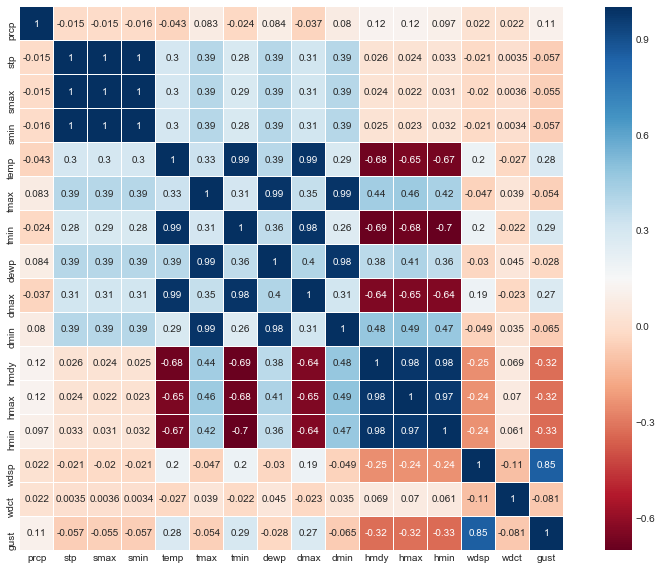

In [29]:
colormap = plt.cm.RdBu
plt.figure(figsize=(15,10))
#plt.title(u'Corelação Pearson das variáveis - Todo conjunto', y=1.05, size=14)
svm = sns.heatmap(dfm.astype(float).corr(),linewidths=0.1,vmax=1.0, 
            square=True, cmap=colormap, linecolor='white', annot=True)

fig = svm.get_figure()
name = '../graphs-br/pearson-base-all.png'
fig.savefig(name,dpi=200)

In [30]:
def f(x):
    if x['prcp'] == 0.0: 
        return '0.0 mm'
    else:        
        return '> 0 mm' 

In [31]:
dfpp = dfm

In [32]:
dfpp['type'] = dfpp.apply(f,axis=1)

In [33]:
dfpp.head(4)

,prcp,stp,smax,smin,temp,tmax,tmin,dewp,dmax,dmin,hmdy,hmax,hmin,wdsp,wdct,gust,type
0,0.0,982.5,982.5,981.3,29.3,12.1,29.7,16.8,25.5,10.8,35.0,58.0,32.0,3.2,101.0,6.5,0.0 mm
1,0.0,983.2,983.2,982.5,29.0,13.5,29.9,13.6,29.0,12.2,39.0,39.0,35.0,3.6,94.0,6.4,0.0 mm
2,0.0,983.5,983.5,983.2,27.4,14.0,29.0,14.0,27.4,13.6,44.0,44.0,39.0,2.5,93.0,6.9,0.0 mm
3,0.0,983.7,983.7,983.4,25.8,16.9,27.4,16.9,25.8,14.1,58.0,58.0,44.0,1.7,96.0,5.8,0.0 mm


In [34]:
for f in DER:    
    dfpp = dfpp.drop(f, 1)
dfpp.head()

,prcp,stp,temp,dewp,hmdy,wdsp,wdct,gust,type
0,0.0,982.5,29.3,16.8,35.0,3.2,101.0,6.5,0.0 mm
1,0.0,983.2,29.0,13.6,39.0,3.6,94.0,6.4,0.0 mm
2,0.0,983.5,27.4,14.0,44.0,2.5,93.0,6.9,0.0 mm
3,0.0,983.7,25.8,16.9,58.0,1.7,96.0,5.8,0.0 mm
4,0.0,983.7,25.4,17.0,57.0,3.1,110.0,7.5,0.0 mm


In [35]:
dfpp.head(4)

,prcp,stp,temp,dewp,hmdy,wdsp,wdct,gust,type
0,0.0,982.5,29.3,16.8,35.0,3.2,101.0,6.5,0.0 mm
1,0.0,983.2,29.0,13.6,39.0,3.6,94.0,6.4,0.0 mm
2,0.0,983.5,27.4,14.0,44.0,2.5,93.0,6.9,0.0 mm
3,0.0,983.7,25.8,16.9,58.0,1.7,96.0,5.8,0.0 mm


In [36]:
import seaborn as sns

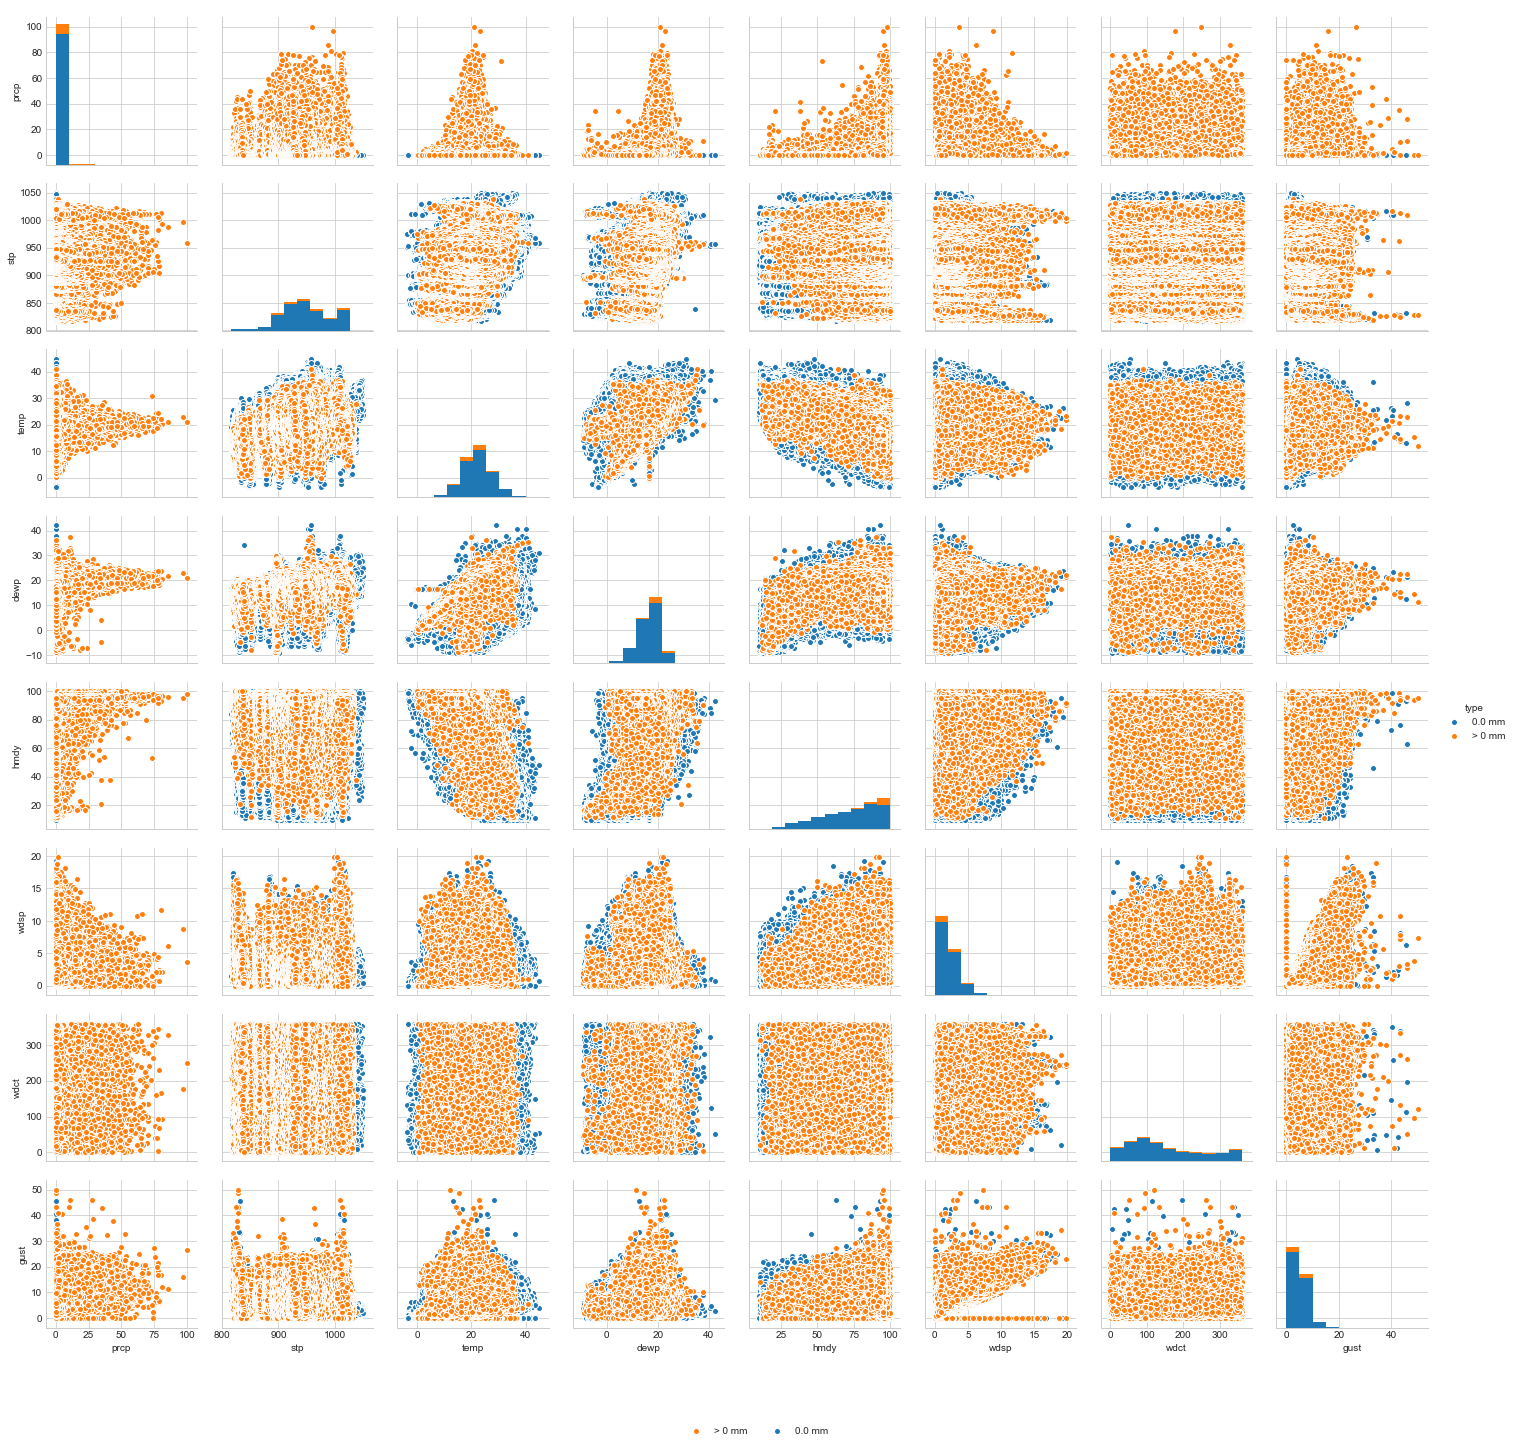

In [37]:
g = sns.pairplot(dfpp,hue='type')
handles = g._legend_data.values()
labels = g._legend_data.keys()
g.fig.legend(handles=handles, labels=labels, loc='lower center', ncol=2)
g.fig.subplots_adjust(bottom=0.08)

In [38]:
name = '../graphs-br/pair_plot_hue_all.png'
g.savefig(name,dpi=100)